In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
total_data = pd.read_csv('millionData.refined.shuf.tsv', sep='\t')
print('전체 리뷰 개수: ', len(total_data))

전체 리뷰 개수:  20302


In [ ]:
total_data[:5]

,label,reviews
0,negative,진짜 너무 없고 각질부각 지속력이 너무 심해요 두번쓰고 못쓰는중입니다
1,negative,18일에 립스틱 3개샀는데 21일에 배송해준다고 하고 2개만 왔고 1 2일 늦을거라...
2,positive,핑크짬바 ㅋㅋ네이밍 진짜 너무 웃기게 잘하는 것 같아요 전 핑크를 좋아하는 핑덕이라
3,negative,분명히 예전에 한번 사용한 제품이라 또 사게 된건데 그 사이에 리뉴얼이 된건지 입술...
4,positive,페리페라 틴트는 잘 안썼는데 생각나서 구매했습니다 보송보송한 느낌도 너무 좋고 색도...


In [ ]:
print(total_data.isnull().values.any())

False


In [ ]:
train_data, test_data = train_test_split(total_data, test_size=0.2, random_state=42)
print('훈련용 리뷰의 개수: ', len(train_data))
print('테스트용 리뷰의 개수: ', len(test_data))

훈련용 리뷰의 개수:  16241
테스트용 리뷰의 개수:  4061


<AxesSubplot:>

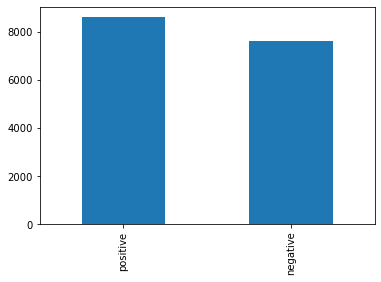

In [ ]:
train_data['label'].value_counts().plot(kind='bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

      label  count
0  negative   7625
1  positive   8616


In [ ]:
train_df = train_data.copy()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16241 entries, 17917 to 15795
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    16241 non-null  object
 1   reviews  16241 non-null  object
dtypes: object(2)
memory usage: 380.6+ KB


In [ ]:
train_df['reviews'] = train_df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_df['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


In [ ]:
test_df = test_data.copy()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4061 entries, 5306 to 17392
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    4061 non-null   object
 1   reviews  4061 non-null   object
dtypes: object(2)
memory usage: 95.2+ KB


In [ ]:
test_df.drop_duplicates(subset='reviews', inplace=True)
test_df['reviews'] = test_df['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['reviews'].replace('', np.nan, inplace=True)
test_df = test_df.dropna(how='any')
print('전처리 후 테스트용 샘플의 개수: ', len(test_df))

전처리 후 테스트용 샘플의 개수:  4059


In [ ]:
mecab = Mecab()

In [ ]:
stopwords = ['페리페라', '페리', '페라', '도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
train_df['tokenized'] = train_df['reviews'].apply(mecab.morphs)
train_df['tokenized'] = train_df['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test_df['tokenized'] = test_df['reviews'].apply(mecab.morphs)
test_df['tokenized'] = test_df['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
negative_words = np.hstack(train_df[train_df.label == 'negative']['tokenized'].values)
positive_words = np.hstack(train_df[train_df.label == 'positive']['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(30))

[('는데', 5141), ('안', 4592), ('입술', 4301), ('너무', 3707), ('어요', 3650), ('색', 3488), ('같', 3320), ('네요', 3199), ('면', 3080), ('바르', 3060), ('했', 2925), ('좋', 2910), ('있', 2859), ('발색', 2785), ('틴트', 2763), ('잘', 2696), ('보', 2602), ('되', 2593), ('거', 2495), ('제품', 2392), ('색상', 2348), ('구매', 2312), ('아요', 2305), ('만', 2280), ('것', 2240), ('나', 2184), ('어', 2178), ('않', 2157), ('지속력', 2115), ('요', 2018)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(30))

[('좋', 7496), ('같', 5265), ('아요', 5216), ('있', 4735), ('어요', 4525), ('잘', 4511), ('는데', 4336), ('색', 4205), ('면', 4057), ('바르', 3976), ('너무', 3938), ('것', 3535), ('색상', 3230), ('제품', 3122), ('틴트', 3085), ('구매', 3048), ('되', 3031), ('지속력', 3026), ('입술', 3020), ('거', 2919), ('립', 2895), ('안', 2854), ('으로', 2825), ('않', 2800), ('쓰', 2604), ('했', 2546), ('로', 2545), ('기', 2518), ('해', 2470), ('습니다', 2456)]


긍정 리뷰의 평균 길이 : 50.65981894150418
부정 리뷰의 평균 길이 : 48.16288524590164


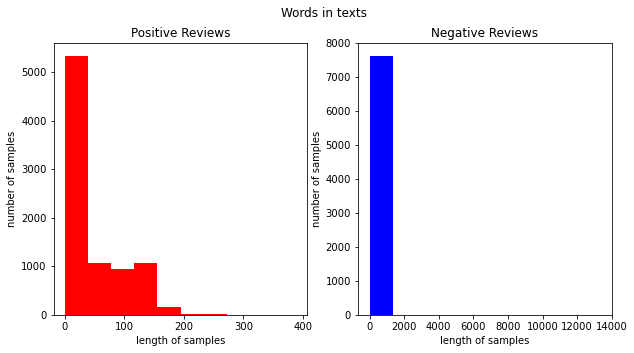

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_df[train_df['label']=='positive']['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_df[train_df['label']=='negative']['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_df['tokenized'].values
y_train = train_df['label'].apply(lambda x: 0 if x == 'negative' else 1)
X_test = test_df['tokenized'].values
y_test = test_df['label'].apply(lambda x: 0 if x == 'negative' else 1)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9871
등장 빈도가 1번 이하인 희귀 단어의 수: 1222
단어 집합에서 희귀 단어의 비율: 12.379698105561747
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.15204167584266798


In [ ]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기: ', vocab_size)

단어 집합의 크기:  8651


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[47, 52, 76, 13, 477, 90, 93, 6, 257, 140, 182, 45, 108, 3952, 34, 8, 5], [6, 572, 11, 10, 2, 152, 55, 12, 1, 77, 429], [1295, 415, 81, 151, 895, 22, 20, 5, 1035, 93]]


In [ ]:
print(X_test[:3])

[[279, 282, 115, 101, 4856, 16, 4, 48, 229, 35, 77, 23, 4857, 1474, 583, 583, 39, 1752, 59, 121, 405, 53, 136, 63, 279, 282, 506, 84, 269, 787, 176, 1243, 50, 1004, 7, 71, 34, 11, 488, 78, 765, 59, 174, 616, 34, 60, 333, 2992, 34, 46, 159, 108, 433, 352, 31, 14, 585, 1146, 75, 573, 152, 3941, 1205, 357, 34, 1179, 6327, 71, 51, 73, 14, 1040, 465, 396, 27, 112, 16, 4, 9, 15, 3023, 29, 279, 282, 174, 405, 22, 20, 3, 201, 174, 7, 1033, 40, 563, 7, 188, 33, 616, 34, 3819, 38, 56, 60, 1384, 86, 219, 15, 813, 83, 5, 84, 578, 223, 241, 127, 278, 757, 85, 211, 38, 127, 857, 2887, 193, 16, 1512, 363, 332, 51, 890, 4301, 49, 1953, 766, 130, 27, 261, 160, 4858, 4, 73, 142, 605, 261, 84, 670, 8, 115, 101, 857, 1083, 955, 334, 1158, 1616, 757, 267, 1512, 379, 143, 46, 85, 85, 2867, 405, 53, 136, 114], [6, 4202, 548, 419, 39, 388, 340, 823, 178, 142, 72, 262, 1537, 20, 3, 62, 322, 12, 20, 5, 419, 18, 243, 45, 12, 729], [308, 12, 119, 360, 150, 5, 69, 6, 131, 256, 78, 189]]


리뷰의 최대 길이 : 13334
리뷰의 평균 길이 : 49.48753155593867


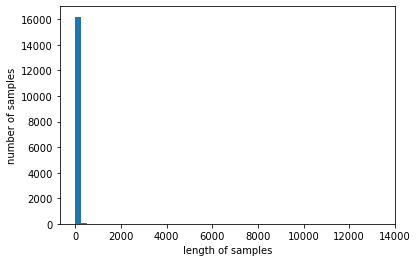

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 190
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 190 이하인 샘플의 비율: 99.15029862693184


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
from keras import backend as K

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=16, validation_split=0.2)

Epoch 1/15
812/812 [==============================] - 10s 12ms/step - loss: 0.3354 - accuracy: 0.8540 - precision: 0.8703 - recall: 0.8670 - f1score: 0.8564 - val_loss: 0.1986 - val_accuracy: 0.9274 - val_precision: 0.9285 - val_recall: 0.9200 - val_f1score: 0.9201

Epoch 00001: val_accuracy improved from -inf to 0.92736, saving model to best_model3.h5
Epoch 2/15
812/812 [==============================] - 10s 12ms/step - loss: 0.1518 - accuracy: 0.9459 - precision: 0.9534 - recall: 0.9440 - f1score: 0.9449 - val_loss: 0.1676 - val_accuracy: 0.9360 - val_precision: 0.9179 - val_recall: 0.9540 - val_f1score: 0.9320

Epoch 00002: val_accuracy improved from 0.92736 to 0.93598, saving model to best_model3.h5
Epoch 3/15
812/812 [==============================] - 10s 12ms/step - loss: 0.1046 - accuracy: 0.9631 - precision: 0.9692 - recall: 0.9615 - f1score: 0.9630 - val_loss: 0.1800 - val_accuracy: 0.9468 - val_precision: 0.9362 - val_recall: 0.9548 - val_f1score: 0.9426

Epoch 00003: val_acc

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 100

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model4.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1score])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=32, validation_split=0.2)

Epoch 1/15
406/406 [==============================] - 6s 14ms/step - loss: 0.3598 - accuracy: 0.8437 - precision: 0.8616 - recall: 0.8675 - f1score: 0.8563 - val_loss: 0.2050 - val_accuracy: 0.9215 - val_precision: 0.9518 - val_recall: 0.8950 - val_f1score: 0.9206

Epoch 00001: val_accuracy improved from -inf to 0.92151, saving model to best_model4.h5
Epoch 2/15
406/406 [==============================] - 5s 13ms/step - loss: 0.1670 - accuracy: 0.9390 - precision: 0.9504 - recall: 0.9348 - f1score: 0.9404 - val_loss: 0.1739 - val_accuracy: 0.9391 - val_precision: 0.9476 - val_recall: 0.9342 - val_f1score: 0.9395

Epoch 00002: val_accuracy improved from 0.92151 to 0.93906, saving model to best_model4.h5
Epoch 3/15
406/406 [==============================] - 5s 13ms/step - loss: 0.1146 - accuracy: 0.9594 - precision: 0.9681 - recall: 0.9561 - f1score: 0.9607 - val_loss: 0.1492 - val_accuracy: 0.9474 - val_precision: 0.9577 - val_recall: 0.9395 - val_f1score: 0.9471

Epoch 00003: val_accura

In [ ]:
from tensorflow.keras.models import load_model

dependencies = {
    'precision': precision,
    'recall': recall,
    'f1score': f1score
}

loaded_model = load_model('best_model4.h5', custom_objects=dependencies)
# print('\n 테스트 정확도: %.4f' %(loaded_model.evaluate(X_test, y_test)[1]))

In [ ]:
_loss, _acc, _precision, _recall, _f1score = loaded_model.evaluate(X_test, y_test)

127/127 [==============================] - 1s 5ms/step - loss: 0.1483 - accuracy: 0.9626 - precision: 0.9723 - recall: 0.9584 - f1score: 0.9639


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('힌스 특유의 분위기있는 색감이 좋아서 자주 구매해요!이번에 올영에 입점하면서 할인도 같이 해서 얼마나 신났는지 모르겠어요ㅎㅎㅎ 립스틱 구매가 주목적이었는데, 3만원 이상 구매시 작은 립스틱 미니 사은품이 온다고 해서 이 틴트고 하나 골랐어요!')

99.44% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('💓지난주에 힌스 프라임 구매하고서 좀 실망해서 고민했던 컬러 얼루어링 구매했는데 얼루어링은 진짜 마스크 벗고 매일매일 바르고싶어요 정말 너무 예뻐요 [ 색상 ] 처음 바를 땐 롬앤 베어그레이프와 매우 비슷하지만 채도가 쪼금 더 높은 편이고 시간이 지나면 아주 쫀쫀하게 차오르는 립이에요 그리고 매우 쿨합니당 [ 지속력 ] 이게 촉촉하고 쫀쫀한 립이라서 입에 머물고 있을 줄 아신다면 진짜 진짜 큰 착각입니다 입술 바르자마자 찐득거리는거 다 사라지고 겉으로 봤을 땐 빤딱빤딱 빛나고 촉촉한데 전혀 찐득하지않고 입술에 착착 감겨서 매우 편해요 지속력도 매우매우 좋구요 시간이 지나면 좀 연해지기는 하지만 그것마저도 진짜 자연스럽고 예뻐요 [ 단점 ] 향은 정말... 안 좋아요  향에 관심도 없고 향도 잘 못 맡고 둔감한 편인데도 냄새가 되게 거부감들었고 매우 세고 좋은 향도 아니라 인위적인 꽃향 같은 게 나요 처음 바를 때 향이 좀 별로여서 아쉬웠어요 향 말고는 단점 없어요')

99.96% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('원래는 프라임이 아닌 다른 색을 생각하고 갔는데 매장에서 테스트해보니 이 색이 저한테는 좀 더 낫겠다는 생각이었습니다. 마침 또 온라인에서 프라임만 품절이라 매장에서 있을 때 얼른 구입했는데 집에 와서 발색해보니 이렇게 제 맘에 쏙 드는 색일 수가 없네요. 톤다운 된 장미에 브라운과 보라를 아주 조금 섞은 듯한 색상인데 너무 오묘한 색이라서 맘에 듭니다. 다만 착색이 없고 잘 지워져서 마스크 안에 바르기엔 좀 힘들 것 같습니다.')

99.95% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('질감은 광택이 조금나면서 쫀쫀하지만 끈적이지는 않는 제형이에요. 얇게 발라도 발색이 잘 되고 그라데이션을 하면 정말 예쁩니다. 클렌징티슈로 닦았는데 착색이 조금 남았어요. 많이 남는 편은 아닙니다. 색깔은 회빛이 조금 포함된 자주색이에요. 화면상으로는 많이 붉은데  실물로는 보라빛이 더 도는 색이에요. 확실하게 쿨톤입니다. 웜톤이 쓰기에는 좀 무리에요. 여름뮤트톤인데 데일리로 정말 예쁜 색이에요. 광택이 도는 특성상 마스크에 묻을 것 같지만 그걸 감수하고도 쓸만큼 예쁜색이에요. 촉촉하고 약간 장미향이 감돌아서 더 좋았어요.')

93.71% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('발색되는거맞아요,,?그냥 립글로즈같애여  ㅜㅜ지속력도 엉망이고 발색도 엉망이에요 너무 찐득거랴서 마스크에 다묻어요 입술에 올려놓으면 얼굴이 수정화장못하고 일에찌든얼굴같이 생기를 잡아먹네요')

75.55% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('롬앤 쥬시래스팅틴트라인보다는 조금 더 쫀득한 느낌이에요 공홈 발색이 너무 곶감색이라 살짝 고민햇는데 오렌지 뒤의 베이스가 맑게 받쳐줘서 분위기있는 색이 됩니다! 롬앤과 비슷한 틴트색상들을 같이 찍어봤어요 뉴 드레프트는 간지템+분위기템 애플브라운은 노란빛이 더 나는편이라 더 따뜻한느낌(가을) 잇도토리는 셋중에 가장 성공률이 높은 무난템입니다!')

99.99% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('매트하지않은 제품이라 구매했는데 발림성 부드러움 너무 좋아요 다만 지속성이 조금 떨어집니다')

99.54% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('올리브영에 입점하자마자 손등에 테스트해보고 발색이 너무 맘에 들어서 구매하게 되었어요~~ 촉촉한 보랏빛의 틴트나 립스틱 종류를 사고싶거나 찾아보는 분들한테 추천합니다! 촉족한 타입이다보니 지속력은 많이 기대하면 안되지만 발색은 되게 고급진 보랏빛이에요,, 말로 표현할 수 없는 오묘한 뮤트톤의 보라색이라서 직접 발라보지 않으면 모를거같아요ㅠㅠ 쿨톤인 분들이 도전해도 잘 어울릴거같은 색이고, 틴트 팁이 무척 부드러워서 스무스하게 발리니까 바를때 촉감도 좋아요! 광택도 생각보다 잘나서 촉촉한 틴트 찾는분들 완전 강추에요! 굳이 단점을 꼽자면 냄새가 별로에요..!')

99.85% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('정말로 최악이네요.. 뭐라고 말이 안 나올 정도')

100.00% 확률로 부정 리뷰입니다.
